# Making deep learning algorithms reproducible: the devil is in the details
## A case study on predicting early COVID-19 infections in China

# 1. Introduction
## 1.1. Preliminary notes

In this notebook, we provide the code along with some descriptions to allow users to replicate or reproduce our work. There are three types of cells used in this notebook: (a) Markdown cells (paper): text from the manuscript used to provide the context of the study; (b) Markdown cells (chunk code description): a one-line short description of the a code cell structured as code chunks (1-48); (c) code cells: Python code lines which execute tasks to reproduce or replicate the work [<sup>1</sup>](#fn1). 

Readers can visualise and run the code lines using the relevant commands in the toolbox (above). Code lines are in Python language, which can be compiled by clicking on the "play button" (▶) in the toolbar above. For better readibility, users can click on the blue column (left side) to collapse all cells (both code and text). 

The project is structured as follows:
* /best-models: a directory which includes all trained and optimal MLP models with checkpoints and weights to be loaded
* /data: a directory which includes all data used and generated withing the project
* /notebooks: a directory which includes all Jupyter notebooks
* /random-search: a directory where the random search algorithm saves files from a model optimization process
* /src & setup.py: a directory and the file which define own utility functions and variables to be used everywhere in the project
* /Dockerfile & /docker-compose.yml: files for describing the Docker configuration to build a replicable environment with all requirements
* /enironment.yml: a file which contains all packages and dependencies for the project to be installed by conda

The subfolder *notebooks* contains the following Jupyter notebook files:
* main notebook: main.ipynb which is the master notebook that includes annotated code and sub-notebooks
* sub-notebooks: 
    + /notebooks/data/preparation.ipynb
    + /notebooks/model/MLP-model.ipynb
    + /notebooks/model/model-comparison.ipynb
    + /notebooks/predictions/generate-fine-scale-feature.ipynb
* code:
    + /src/utils/\_\_init\_\_.py
    
[<sup id="fn1">1</sup>](#fn1-back) _We only used Python as programming language in our work but other programming languages such as R can also be used in a Jupyter notebook. To get a quick introduction to JupyterLab: https://www.youtube.com/watch?v=A5YyoCKxEOU _

## 1.2 Context of our study

Our research group has been conducting a project to understand and predict the spread of COVID-19 in China using deep learning algorithms. These biologically-inspired algorithms are becoming increasingly common in our society and have the potential to facilitate advances in science due to their ability to autonomously learn a model from complex and large datasets. However, the outputs of these so-called "black-box" algorithms are often difficult to reproduce due to their inherent randomness, which can erode trust between modelers and decision makers. In a case study focused on the spatial predictions of early COVID-19 cases in China, we introduce an interactive notebook to highlight essential components of reproducibility to make the results of deep learning algorithms trustworthy. 

Davit Svanidze, a student in our group, was particularly interested in this topic and decided to apply his background in computer science to the problem. Davit quickly realised that his thesis supervisors would not be able to fully assess the quality of his work unless they were able to replicate it. He knew that most of the important information about his project could be found in the code, rather than the written thesis, which only summarised his work. He decided to do everything he could to make his work fully replicable. This required a lot of extra effort, but he was determined to ensure that his supervisors would be able to fully understand and evaluate his project. After Davit graduated, we wanted to share his work with a wider audience. We hope that other students will be able to follow in Davit's footsteps and use his project as a model for their own research. The RSS Real World Data Science platform is a great opportunity for us to make his work visible to everyone.


# 2. Method
## 2.1. Data

During the pandemic, spatially disaggregated (city-level) COVID-19 data have been collected in China by two major providers: the Chinese news agency “The Paper” (Pengpai News agency, 2020) and Xu et al. (2020). Meanwhile, Johns Hopkins University Center for Systems Science and Engineering (JHU) has provided an online platform to allow users to download and visualize regularly updated data worldwide. This is currently the most comprehensive database on COVID-19 worldwide aggregated at national or district/province levels (JHU CSSE, 2020; Dong, Du, and Gardner, 2020).

This study uses 2,321 observations geo-located COVID-19 data from Xu et al. (2020) gathered in China and aggregated temporally between January and March 2020. The original data is composed of positive-only COVID-19 cases (622 observations), which were complemented by 1,699 background data (also-called pseudo-absence data) following the procedure described in Barbet-Massin et al. (2012). Our response represents the (log) rate of COVID-19 infections (number of positive cases per 100,000 population) reported between January and March 2020 per grid-cell. To mitigate the effects of outliers (extreme high values of COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) in Wuhan), the response is logged and expressed as: log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020).

We consider seven relevant predictive features. We account for the geolocation of the observations (LONG and LAT), which can be associated with the onset and the rate of the spread of COVID-19. Cities in the east and in the north of China tended to record COVID-19 cases earlier, than those in the west and in the south (Zhang, Zhang, and Wang, 2020). In China, the initial COVID-19 outbreak is mainly explained by human movement (Kraemer et al., 2020) and distance to the initial focus presumably located in the city of Wuhan (Liu, 2020). Furthermore, given the importance of human-to-human COVID-19 transmission, densely populated areas are more at risk to encounter higher incidence rates and exhibit a larger number of total confirmed cases (Maier and Brockmann, 2020; Tian et al., 2020). Therefore, the model includes travel time to: (i) the nearest city with a population of more than 50,000 (Weiss et al., 2018) (ACCESS); and (ii) to Wuhan (WACCESS) and controls for population size (POP) using WorldPop (Tatem, 2017) and urban footprint (URBAN) (Liu, 2020; Pirouz et al., 2020) (URBAN) using the Global Urban Footprint data (Esch et al., 2017).

While climatic and meteorological factors might have played a minor role in the transmission of COVID-19, humidity could facilitate the transmission of the virus and has shown a positive correlation with the number of total confirmed cases of COVID-19 in China (Liu et al., 2020). In order to account for potential variability in air transmission, we include humidity by potential evapotranspiration (PET), which measures the potential amount of evaporation.

To improve the model stability, we transformed the features using a quantile normalization technique (Bolstad et al., 2003), except LONG (-180 to 180 degrees) and LAT (-90 to 90 degrees) which are transformed by dividing them by their respective highest absolute value. A total number of 812 non-missing observations are used for model training, validation and testing.

There are various approaches to assess COVID-19 risk at fine spatial scale. One may model COVID-19 total confirmed cases (Jan-Mar 2020) (TC) in each grid-cell. While TC provides a relevant risk metric, modeling it directly makes its interpretation difficult. Cities with a high TC might not necessarily be more at risk than those with a lower TC, since cities with larger population size are likely to exhibit larger values of TC. In order to mitigate this issue, we normalized the target variable (response) by the adjusted population size (VAPOP) estimated for each area surrounding the observed locations delimited by Voronoi polygons (Burrough et al., 2015, pp. 160) and computed the incidence rate per 100,000 (IR) (Equation A1). Further, to mitigate the effects of outliers (extreme high values of IR in Wuhan), we define the resulting target variable as logged IR (LIR, see Equation A2).

\begin{equation}
\text{IR} = \dfrac{\text{TC}}{\text{VAPOP}} \times 100,000 \qquad \text{(A1)}
\end{equation}

\begin{equation}
\text{LIR} = \ln (\text{IR} + 1) \qquad \text{(A2)}
\end{equation}

<pre>
<b>Code chunk 1</b>: import all necessary Python librairies 
</pre>

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from utils import ROOT_DIR, get_data

# %load_ext autoreload
# %autoreload 2

%matplotlib inline

<pre>
<b>Code chunk 2</b>: import data on COVID-19 (aggregated Jan-March 2020) and features
</pre>

In [54]:
raw_data = pd.read_csv(ROOT_DIR + "/data/csvs/rawdata.csv")
raw_data.head()

,id,LONG,LAT,TC,voronoi_pop,nbHF,VAPOP,sampling,provnames,ACCESS,PET,POP,URBAN,WACCESS
0,1,109.5792,18.29187,4.0,294324.531250,1,294324.531250,1,Hainan,-0.625080,1.346743,2.067364,1.284664,2.655904
1,2,109.7180,18.36956,2.0,73959.992188,1,73959.992188,1,Hainan,NaN,NaN,NaN,NaN,NaN
2,3,109.4197,18.39084,60.0,218175.828125,1,218175.828125,1,Hainan,-0.737850,1.160834,0.871805,0.716921,2.674515
3,4,109.9475,18.56796,6.0,322905.031250,1,322905.031250,1,Hainan,-0.523366,1.269342,1.113280,0.613657,2.634486
4,5,109.0491,18.65009,4.0,465194.500000,1,465194.500000,1,Hainan,-1.265526,1.233569,0.818068,0.533877,2.691532


<pre>
<b>Code chunk 3</b>: identify remote locations: summary of observations with ACCESS values equal or above the 95% percentile
</pre>

In [3]:
raw_data.query("ACCESS >= ACCESS.quantile(0.95)").describe()

,id,LONG,LAT,TC,voronoi_pop,nbHF,VAPOP,sampling,ACCESS,PET,POP,URBAN,WACCESS
count,116.000000,116.000000,116.000000,0.0,1.160000e+02,116.0,1.160000e+02,116.0,116.000000,116.000000,116.000000,116.000000,116.000000
mean,488.000000,86.595187,34.558549,NaN,5.672673e+05,1.0,5.672673e+05,0.0,2.084007,-0.771653,-1.525421,-0.473654,1.164811
std,75.437161,3.415915,1.624140,NaN,8.879940e+05,0.0,8.879940e+05,0.0,0.367594,0.582523,0.407935,0.095290,0.433135
min,181.000000,78.270833,29.520833,NaN,1.039871e+05,1.0,1.039871e+05,0.0,1.652304,-2.363020,-1.974678,-0.482502,0.169923
25%,481.000000,84.364583,33.270833,NaN,1.039871e+05,1.0,1.039871e+05,0.0,1.819137,-1.159394,-1.974678,-0.482502,0.790319
50%,481.000000,86.395833,34.520833,NaN,5.158962e+05,1.0,5.158962e+05,0.0,1.962916,-0.667736,-1.505685,-0.482502,1.147461
75%,559.000000,88.895833,35.770833,NaN,5.158962e+05,1.0,5.158962e+05,0.0,2.262050,-0.367431,-1.305703,-0.482502,1.457051
max,559.000000,101.395833,37.645833,NaN,8.842163e+06,1.0,8.842163e+06,0.0,3.444752,0.387251,-0.099741,0.543802,2.391888


<pre>
<b>Code chunk 4</b>: identify sparsely populated areas: summary of observations with POP values below or equal to the 5% percentile
</pre>

In [4]:
raw_data.query("POP <= POP.quantile(0.05)").describe()

,id,LONG,LAT,TC,voronoi_pop,nbHF,VAPOP,sampling,ACCESS,PET,POP,URBAN,WACCESS
count,116.000000,116.000000,116.000000,0.0,1.160000e+02,116.0,1.160000e+02,116.0,116.000000,116.000000,1.160000e+02,116.000000,116.000000
mean,455.637931,91.805316,38.319325,NaN,1.010822e+06,1.0,1.010822e+06,0.0,1.212095,0.313605,-1.974678e+00,-0.448281,0.669802
std,90.088401,5.639838,2.544643,NaN,8.760660e+05,0.0,8.760660e+05,0.0,0.639987,1.397401,8.920317e-16,0.183107,0.506022
min,349.000000,80.770833,33.270833,NaN,1.039871e+05,1.0,1.039871e+05,0.0,-0.414080,-2.363020,-1.974678e+00,-0.482502,-0.267109
25%,352.000000,88.895833,36.395833,NaN,1.039871e+05,1.0,1.039871e+05,0.0,0.653575,-0.997434,-1.974678e+00,-0.482502,0.375073
50%,481.000000,91.083333,38.270833,NaN,5.158962e+05,1.0,5.158962e+05,0.0,1.308815,0.214757,-1.974678e+00,-0.482502,0.588537
75%,559.000000,95.770833,40.145833,NaN,1.885811e+06,1.0,1.885811e+06,0.0,1.766923,1.625414,-1.974678e+00,-0.482502,0.791633
max,603.000000,104.520833,45.770833,NaN,3.051850e+06,1.0,3.051850e+06,0.0,2.424813,2.747000,-1.974678e+00,0.681398,2.028019


<pre>
<b>Code chunk 5</b>: generate pseudo-absence data: set TC 'NA' values to 0 in remote and sparsely populated areas and summary
</pre>

In [5]:
# Replace TC NaN values with 0 values, when ACCESS is higher than 95 Percentile of ACCESS values
raw_data_transformed = raw_data.copy()
raw_data_transformed["TC"] = np.where(raw_data_transformed["ACCESS"] >= raw_data_transformed["ACCESS"].quantile(0.95), 0, raw_data_transformed["TC"])
raw_data_transformed["TC"] = np.where(raw_data_transformed["POP"] <= raw_data_transformed["POP"].quantile(0.05), 0, raw_data_transformed["TC"])

# Number of zero values
print("Number of data points with TC = 0:\n{}".format(len(raw_data_transformed.query("TC == 0"))), "\n")

# Drop NA data points
raw_data_transformed = raw_data_transformed.dropna()
raw_data_transformed.describe()

Number of data points with TC = 0:
193 



,id,LONG,LAT,TC,voronoi_pop,nbHF,VAPOP,sampling,ACCESS,PET,POP,URBAN,WACCESS
count,812.000000,812.000000,812.000000,812.000000,8.120000e+02,812.000000,8.120000e+02,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000
mean,343.961823,107.498655,33.592855,50.710591,1.949372e+06,1.019704,1.928856e+06,0.762315,-0.481589,0.118251,0.672332,0.788644,-0.429321
std,172.787054,12.152613,6.278269,474.470778,1.949150e+06,0.139068,1.938481e+06,0.425927,1.409672,0.781895,1.576832,1.164337,1.106955
min,1.000000,78.270833,18.291870,0.000000,1.699957e+04,1.000000,1.699957e+04,0.000000,-3.487341,-2.363020,-1.974678,-0.482502,-3.676348
25%,199.750000,101.395833,29.521206,2.000000,5.158962e+05,1.000000,5.158962e+05,1.000000,-1.493258,-0.399133,-0.216299,-0.482502,-1.127073
50%,365.500000,109.904050,34.279290,4.000000,1.368634e+06,1.000000,1.368634e+06,1.000000,-0.734903,0.173306,0.907536,0.798634,-0.720350
75%,481.000000,116.805175,37.645833,22.000000,2.589056e+06,1.000000,2.580963e+06,1.000000,0.301102,0.575787,1.758941,1.581750,0.308398
max,614.000000,132.546400,49.717850,13243.000000,1.390106e+07,2.000000,1.390106e+07,1.000000,3.444752,2.789949,4.630500,4.335167,2.691532


<pre>
<b>Code chunk 5</b>: response transformation, feature standardization and selection, and data summary
</pre>

In [6]:
# Add a new variable IR which is (TC/VAPOP)*100,000
raw_data_transformed["IR"] = (raw_data_transformed["TC"] / raw_data_transformed["VAPOP"]) * 100000

# Drop not used variables from the table and set this table to data, 
# which will be used for other calculations
data = raw_data_transformed.drop(["id", "voronoi_pop", "VAPOP", "nbHF", "TC", "sampling", "provnames"], axis=1)

# Standardize data
data["IR"] = np.log(data["IR"] + 1)
data["LONG"] = data["LONG"] / 180
data["LAT"] = data["LAT"] / 90

print("Summary statistics of the data used in the model. The selected features include: geographic coordinates longitude (LONG) and latitude (LAT), travel time to the nearest city with a population exceeding 50,000 (ACCESS), potential evapotranspiration (PET), population size (POP), urbanity (URBAN) and travel time to Wuhan (WACCESS). The target variable (response) is log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (IR). LONG and LONG values are divided by their absolute value and the other features are transformed with a quantile normalization technique (Bolstad et al., 2003).", "\n")
# Summary of data from "/data/csvs/data.csv" (http://c100-159.cloud.gwdg.de:9009/lab/tree/data/csvs/data.csv)
(data[["LONG", "LAT", "ACCESS", "PET", "POP", "URBAN", "WACCESS", "IR"]]
     .describe()
     .round(4))

Summary statistics of the data used in the model. The selected features include: geographic coordinates longitude (LONG) and latitude (LAT), travel time to the nearest city with a population exceeding 50,000 (ACCESS), potential evapotranspiration (PET), population size (POP), urbanity (URBAN) and travel time to Wuhan (WACCESS). The target variable (response) is log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (IR). LONG and LONG values are divided by their absolute value and the other features are transformed with a quantile normalization technique (Bolstad et al., 2003). 



,LONG,LAT,ACCESS,PET,POP,URBAN,WACCESS,IR
count,812.0000,812.0000,812.0000,812.0000,812.0000,812.0000,812.0000,812.0000
mean,0.5972,0.3733,-0.4816,0.1183,0.6723,0.7886,-0.4293,0.6104
std,0.0675,0.0698,1.4097,0.7819,1.5768,1.1643,1.1070,0.7730
min,0.4348,0.2032,-3.4873,-2.3630,-1.9747,-0.4825,-3.6763,0.0000
25%,0.5633,0.3280,-1.4933,-0.3991,-0.2163,-0.4825,-1.1271,0.0639
50%,0.6106,0.3809,-0.7349,0.1733,0.9075,0.7986,-0.7204,0.3355
75%,0.6489,0.4183,0.3011,0.5758,1.7589,1.5818,0.3084,0.8333
max,0.7364,0.5524,3.4448,2.7899,4.6305,4.3352,2.6915,4.8898


<pre>
<b>Code chunk 6</b>: define a function to split all features and the target variable into training, validation and test sets
</pre>

In [7]:
def train_val_test_split(X, Y):
    # Set the seed number 201 to replicate this split everytime
    random_state = 201
    # In the first step, split data in training and test sets (80%/20%) 
    _X_train, X_test, _Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=random_state)

    # In the second step, split the previous training set into training and validation sets (75%/25%)
    # We need 75%/25% split here, because training set was already 80% and this split give 60%/20% of the whole data
    # Ultimately, data is split in 60%/20%/20% (training/validation/test) sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(
        _X_train, _Y_train, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2
    return X_train, Y_train, X_validation, Y_validation, X_test, Y_test

<pre>
<b>Code chunk 7</b>: rename the features and the target variable and generate training, validation and test sets
</pre>

In [8]:
# create a dataframe with all training data except the target column
X = data.drop(columns=["IR"])

# create a dataframe with only the target column
Y = data[["IR"]]

# The same as get_data() from train.csv, validation.csv and test.csv
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = train_val_test_split(X, Y)

## 2.2 Model: multilayer perceptron implementation

We consider a multilayer perceptron (MLP), which is a class of DL models (Ramchoun et al., 2016). We use this model to predict COVID-19 within grid-cells of about 5 x 5 km<sup>2</sup> resolution across mainland China. The artificial neural network (ANN) architecture of the model allows us to learn complex non-linear relationships and interactions that are expected between socioeconomic and environmental predictors and COVID-19 (Yang, Jiang, and Guo, 2019).

We evaluate the predictive performance of the model during three phases: (1) training (model building); (2) validation (tuning); and (3) testing. To do so, we split the data randomly into three parts: training (60%), validation (20%), and testing (20%). We ensure that data used in the final testing has not been used to build or train the model. We use the mean squared error loss function to assess the model predictive performance, which is commonly used for this type of target variable (log IR).

The MLP model can be composed of zero, one or several hidden layers. Each hidden layer is composed of hidden units. We use a non-linear activation function (rectified linear unit) for the hidden units to learn the relationship between the features and the target (Brownlee, 2018, p. 141), which is expected to be complex and non-linear in the context of contagious diseases (Bhatt et al., 2017). To decrease the training time and improve the model performance and stability, we adopt batch normalization (BN), which is a widely-used technique to normalize z values in hidden layers (Goodfellow, Bengio, and Courville, 2016, pp. 168). The z values are defined as the sum of the current neuron bias and aggregation of the current neuron weights with the activation values from the previous layer. BN has a slight regularization effect and decreases the impact of weight initialization on model performance (Ioffe and Szegedy, 2015). We use a batch size of 96, as suggested in Goodfellow, Bengio, and Courville (2016). To reduce overfitting and improve generalization error we randomly drop out nodes during training. To optimize the MLP models we use the Adam optimizer, which can achieve high predictive performance while reducing the computation costs (Kingma and Ba, 2015).

## 2.3. Model implementation and parametrization

We use a cloud server with 32 processor cores and 128 gigabyte random-access memory (RAM) to run the investigated DL (MLP) model. For MLP, the choice of the number of layers and hidden layers, along with the main parameters are described in further details below.

To evaluate the model while building and tuning the model, we split the data randomly into three parts: training (60%), validation (20%), and test (20%) categories using the Python library scikit-learn (Pedregosa et al., 2011). Note that the proportion of the data uses for each category could be amended according to the study context. For very large datasets, the training set can include a larger proportion of observations, since a small proportion used for validation and test may still represent a large number of observations in absolute terms, and can therefore suffice to assess the predictive performance of the investigated models.

Recall that our target variable log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (LIR) is a continuous scaled variable and our predictive study refers to a regression problem. Hence, a suitable function should be selected to optimize the model. Common loss functions include the mean squared error (MSE), mean squared logarithmic error (MSLE), and the mean absolute error (MAE). MSE is the average of squared differences between true target values and predicted values. As all errors are squared, it disproportionately penalizes models producing larger errors. This is particularly useful in the presence of outliers. By construction (Equation A3), MSLE does not strongly penalize large differences between predictions and observations, which could be appropriate with unscaled targets (Brownlee, 2018, p. 60).

 \begin{equation}
    \text{MSLE} = \dfrac{1}{N} \sum_{i=1}^{N}(\ln(y_{i} + 1) - \ln({\hat{y}}_{i} + 1))^{2} \qquad \text{(A3)}
\end{equation}

Alternatively, the MAE loss is often used when the distribution of the target variable is approximately Gaussian, but has outliers (Brownlee, 2018, p. 62). By measuring the sum of absolute differences between true and predicted target variable values, the metric is more robust to outliers (Equation A4) and is suitable for target variable that are not scaled. 

\begin{equation}
\text{MAE} =  \dfrac{1}{N} \sum_{i=1}^{N} |y_{i} - \hat{y}_{i}| \qquad \text{(A4)}
\end{equation}

We use the MSE loss, because the target variable (LIR) is scaled and therefore exhibit a small number of outliers. However, some outliers remain (e.g. very large LIR in Wuhan, where COVID-19 was initially identified) and need to be well estimated to provide sufficiently accurate and reliable predictive maps for policy-makers.

## 2.4. Parameterizing the multilayer perceptron (MLP) model

There are various aspects that need to be considered to parameterize the MLP model. First, the number of hidden layers needs to be chosen. There is no a priori rule to determine the number of hidden layers, but parsimony should be favored. Models with a large number of hidden layers are more likely to lead to overfitting issues and are computationally more expensive (Brownlee, 2018, p. 23). Furthermore, Woods and Bowyer (1997) demonstrates that any complex and non-linear function can be estimated with a single hidden layer. To assess the effect of the number of layers on the predictive performance of the MLP model, we specify three parsimonious models: (1) without a hidden layer; (1) with one hidden layer; and (3) with two hidden layers.

Each hidden layer consists of hidden units. Models tend to perform better with a high ratio of hidden units per hidden layer and a constant ratio across each hidden layer (Bengio, 2012; Larochelle et al., 2009), but may vary according to the dataset. In addition, it is recommended to have a larger number of hidden units than features (input units) although, increasing the number number of hidden units leads to higher computational costs (Bengio, 2012). Following these recommendations, we initialize our MLP with 128 hidden units and evaluate the predictive performance with variations of the number of hidden units.

We associate non-linear activation function to hidden units to learn the relationship between the feature and the target, which is expected to be complex and non-linear (Brownlee, 2018, p. 141). There are three commonly-used activation functions: the sigmoid function, the hyperbolic tangent function (TanH) and the rectified linear unit (ReLU). The choice of the activation function depends on the context. Sigmoid and TanH activation functions have an S-shaped curve, but exhibit a different range of output values. By construction, below or above a certain threshold, the output saturates to a fixed value. Both activation functions are however sensitive to changes for small input values close to 0. As a result, training is computationally expensive and models with these activation functions often may not perform well.

In order to overcome the saturation problem, we chose ReLU as activation function. It is a non-linear function that is sensitive to the entire range of positive input values, but also enables the model to learn complex relationships. Given its computational advantages along with the ease to estimate the function’s derivative, ReLU has contributed to the growth and extensive application of DL algorithms (Brownlee, 2018, p. 143). ReLU can be problematic in the presence of large negative bias, which can be mitigated through ReLU extensions (Brownlee, 2018). Since our target variable, log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (LIR), is non-negative, ReLU appears to be a suitable activation function.

We apply regularization techniques to decrease the variance and avoid overfitting. The most common regularization techniques are: L1, L2 and dropout. The main idea is to penalize model complexity through weights (Brownlee, 2018, p. 247). Both L1 and L2 constrain weight values by adding a regularization term (penalty) in the loss function (Tikhonov, 1943), such that the model learns to decrease the weight values until the optimal weights and loss are achieved. In contrast, dropout constrains the number of weights without adding any regularization term in the loss function.

Dropout has been widely adopted, because it not only regularizes a model, but also makes it more robust since it offers the possibility to systematically consider numerous parsimonious neural networks through the randomized procedure applied to drop hidden units (Phaisangittisagul, 2016). We therefore select the dropout approach using default dropout rates (0.5-0.8) (Garbin, Zhu, and Marques, 2020) and explore additional values between 0.1 to 0.9 to ensure that we select the most suitable rate for our case study.

In order to decrease the training time and improve the model performance and stability, we adopt a batch normalization (BN) technique, which normalizes z values in hidden layers. In addition, BN has a slight regularization effect and decreases the impact of weight initialization on model performance and has been widely used (Ioffe and Szegedy, 2015).

## 2.5. Model optimizatation

As a means to optimize the MLP models, various gradient optimization algorithms can be used. They commonly perform backpropagation to adjust the weights and biases of units and minimize the loss function of neural network models (Rumelhart, Hinton, and Williams, 1986). For this purpose, derivatives of the loss function are calculated and evaluated. Subsequently, gradients of weights and biases are passed to the units from the last to the first layer (backwards) and adjusted with the learning rate such that the model accuracy is improved.

Popular algorithms include the batch gradient descent, gradient descent (GD), and additional versions which use different batch size, i.e. number of training examples that go through a neural network in each iteration and different criteria to set the timing from which loss and derivative calculations are performed. As a means to decrease training time while achieving better optima, more sophisticated algorithms have been proposed, which include: an extension of GD: SGD with momentum, root mean square propagation (RMSProp), and adaptive moment estimation (Adam). These algorithms differ only by calculating and scaling the derivative terms to find the optimum. Rumelhart, Hinton, and Williams (1986) proposed SGD with momentum, which uses exponentially weighted averages to smooth the noise (oscillations) that might prevent or increase the necessary time for the model to reach the optimum.

Adam combines the benefits of both SGD with momentum and RMSProp algorithms and has achieved good results in various studies (Kingma and Ba, 2015). Therefore, we chose Adam as optimization algorithm. In order to increase the chance that an optimum is reached while keeping the computational time reasonable, we explore a range of plausible values for the learning rate by taking suggestions from the literature. We initiate the learning rate with a value 0.01 and decrease it for each iteration.

Batch size describes how many training examples go through a neural network in each iteration. We define an initial batch size of 64 and explore additional batch sizes: 32, 96 and 128. Depending on batch size there is a trade-off between model generalisability and training time. Hence, these batch sizes are optimal for this study (Goodfellow, Bengio, and Courville, 2016). In addition, we need to set the epoch, which is defined as a single pass through the full training set examples (Nielsen, 2015). More epochs are needed to train a model with a low learning rate. We set a relatively high number of epochs (10,000) and added an early stopping algorithm to stop the training process before the maximum number of epochs is reached if the validation loss does not improve further (Prechelt, 1998).

<pre>
<b>Code chunk 8</b>: import all necessary Python librairies 
</pre>

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import ROOT_DIR, get_data
from shutil import rmtree

# %load_ext autoreload
# %autoreload 2

%matplotlib inline

<pre>
<b>Code chunk 9</b>: define the structure of the MLP models (config) used for training
</pre>

In [10]:
# Set a constant which includes important config data to train MLP0, MLP1 and MLP2
MODEL_CONFIGS = {
    "hidden_layers_0": {
        "n_layers": 0,
        "random_search_project_name": "covid-19-nn-0",
        "random_seed": 5959,
        "model_save_path": ROOT_DIR + "/best-models/mlp/hidden-layers-0",
    },
    "hidden_layers_1": {
        "n_layers": 1,
        "random_search_project_name": "covid-19-nn-1",
        "random_seed": 1184,
        "model_save_path": ROOT_DIR + "/best-models/mlp/hidden-layers-1",
    },
    "hidden_layers_2": {
        "n_layers": 2,
        "random_search_project_name": "covid-19-nn-2",
        "random_seed": 4442,        
        "model_save_path": ROOT_DIR + "/best-models/mlp/hidden-layers-2",
    }
}

<pre>
<b>Code chunk 10</b>: option to activate or deactivate model training
</pre>

In [11]:
# IMPORTANT OPTION !
# the object TRAINING should be set to False to run the entire code within a reasonable time frame. If set to True, the training process could take several days
# unless you aim to carry out a complete review of the code, we highly recommend users to keep it as False.
TRAINING = False

<pre>
<b>Code chunk 11</b>: define variables for model training
</pre>

In [12]:
# Get number of columns in training data
n_cols = X_train.shape[1]

# Set a number of maximum RandomSearch runs to find an optimal model
max_trial = 1000

# Initialise EatlyStopping algorithm, which stops training and saves weights when the model does not improve further
early_stopping_monitor = EarlyStopping(monitor="val_loss", patience=100)

<pre>
<b>Code chunk 12</b>: define a function to initialize and train the MLP models for the random search algorithm
</pre>

In [13]:
# Initialise different models MLP0, MLP1 or MLP2 for random search algorithm depending on its hyperparameters (hp)
def build_model(hp):
    model = Sequential()
    # Add an input layer
    model.add(InputLayer(input_shape=(n_cols,)))
    
    # Add hidden layers only for MLP1 and MLP2
    if current_model_config["n_layers"] >= 1:
        num_units_per_layer = hp.Int('units_per_hidden_layer', 
                                     min_value=32,
                                     max_value=4096, 
                                     step=32)
        dropout_rate_per_layer = hp.Float('dropout_per_hidden_layer',
                                          min_value=0.0,
                                          max_value=0.9,
                                          step=0.1,
                                          default=0.5)
        
        # Simillarly parametrize each hidden layer
        for i in range(hp.Choice('num_layers', values=[current_model_config["n_layers"]])):
            # Add a hidden layer to MLP
            model.add(Dense(units=num_units_per_layer,
                            kernel_initializer='he_uniform',
                            bias_initializer='zeros'))
            # Use an Batch Normalization layer to stabilise the model 
            model.add(BatchNormalization())
            # Use an activation layer
            model.add(Activation("relu"))
            # Use an dropout layer to regularise the model 
            model.add(Dropout(rate=dropout_rate_per_layer))
    
    # Add an output layer
    model.add(Dense(1, 
                    kernel_initializer='he_uniform',
                    bias_initializer='zeros'))
    # Use an Batch Normalization layer to stabilise the model
    model.add(BatchNormalization())
    # Use an activation layer
    model.add(Activation("relu"))
    
    # Initialise the model to optimise with defined parameters
    model.compile(optimizer=Adam(hp.Choice('learning_rate',
                                           values=[0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125])),
                  loss='mean_squared_error',
                  metrics=[metrics.RootMeanSquaredError(), metrics.MeanAbsoluteError(), metrics.MeanAbsolutePercentageError(), metrics.MeanSquaredLogarithmicError()])
    return model

<pre>
<b>Code chunk 13</b>: train and find the optimal MLP models by random search algorithm
</pre>

In [14]:
# Since we already ran the computationaly intensive random search algorithm and found optimal models,
# they are saved with their structure and weights in the following directories
# MLP0: /best-models/mlp/hidden-layers-0
# MLP1: /best-models/mlp/hidden-layers-1
# MLP2: /best-models/mlp/hidden-layers-2

# This will only run if TRAINING=True, which is a computationally intensive and time consuming task
if TRAINING:
    tuners = {}
    best_model = {}

    for model_type in ['hidden_layers_0', 'hidden_layers_1', 'hidden_layers_2']:
        current_model_config = MODEL_CONFIGS[model_type]

        # Initialise the random search algorithm
        tuners[model_type] = RandomSearch(
            build_model,
            seed=current_model_config['random_seed'],
            objective="val_loss",
            max_trials=max_trial,
            executions_per_trial=3,
            directory=ROOT_DIR + "/random-search",
            project_name=current_model_config["random_search_project_name"])

        # Use .values to convert pandas dataframe to numpy array
        # To avoid the Warning -> WARNING:tensorflow:Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
        # Run an optimisation process
        tuners[model_type].search(X_train.values, Y_train.values,
                     epochs=10000,
                     batch_size=96,
                     validation_data=(X_validation.values, Y_validation.values),
                     verbose=0,
                     callbacks=[early_stopping_monitor])

        # Log structures of the optimal models
        print("\n\n######## Get the best trained model of '{}'  ######## \n\n".format(model_type.replace("hidden_layers_", "MLP")))
        best_model[model_type] = tuners[model_type].get_best_models()[0]
        print(best_model[model_type].summary())
        print(tuners[model_type].results_summary(1))

# 3. Results

## 3.1. Model selection

Using a total of 812 observations (training set (486 observations), validation set (163 observations), and test set (163 observations), we compare the predictive performance and select the best model by comparing the root mean squared error (RMSE) metric computed for three parsimonious multilayer perceptron models (initialized with 128 hidden units): (1) without a hidden layer (MLP0); (2) with one hidden layer (MLP1); and (3) with two hidden layers (MLP2). Table 1 provides the RMSE estimated for training, validation and test sets of the three investigated models.

We select MLP1 since it performs best on the training, validation and test sets (bold values in Table 1). Hyperparameters of MLP models are optimized by random search algorithms and training is stopped by early stopping algorithm, when RMSE does not improve on validation set. The optimal hyperparameters of the selected model are 64 hidden units, 0.8 dropout rate, 0.005 learning rate and a batch size of size 96 and 800 epochs. To ensure R & R, note that we include a random seed (equal to 1184) associated with the weight initialization.

<br>
<span style="font-size:12px">Table 1 [generated by code chunk 18]: The root mean squared error (RMSE) metric is computed for the training, validation, and test sets of three multilayer perceptron (MLP) models with : 0 hidden layer (MLP0), 1 hidden layer (MLP1), and 2 hidden layers (MLP2). The target variable is COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (IR). The results of the best performing model are in bold characters.</span>

| Model  | hidden layer | training   | validation | test       |
| ------ | ------------ | ---------- | ---------- | ---------- |
| MLP0   | 0            | 0.70       | 0.68       | 0.66       |
| MLP1   | 1            | ***0.63*** | ***0.62*** | ***0.63*** |
| MLP2   | 2            | 0.68       | 0.63       | 0.66       |
| Nb.obs |              | 486        | 163        | 163        |

<br>

<pre>
<b>Code chunk 14</b>: import all necessary Python librairies 
</pre>

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import ROOT_DIR, get_data
from joblib import load

# %load_ext autoreload
# %autoreload 2

%matplotlib inline

<pre>
<b>Code chunk 15</b>: define predictive performance metrics used to compare the MLP models
</pre>

In [16]:
data_sets = {
    "training": (X_train, Y_train),
    "validation": (X_validation, Y_validation),
    "test": (X_test, Y_test)
}

sets = {
    "training": None,
    "validation": None,
    "test": None
}

description = {
    "model": None,
    "predictions": {**sets},
    "rmse": {**sets},
    "mae": {**sets},
    "R2": {**sets}
}

models = {
    "MLP0": {**description},
    "MLP1": {**description},
    "MLP2": {**description}
}

models["MLP0"]["model"] = tf.keras.models.load_model(ROOT_DIR + "/best-models/mlp/hidden-layers-0")
models["MLP1"]["model"] = tf.keras.models.load_model(ROOT_DIR + "/best-models/mlp/hidden-layers-1")
models["MLP2"]["model"] = tf.keras.models.load_model(ROOT_DIR + "/best-models/mlp/hidden-layers-2")

rmseDf = pd.DataFrame(index=[model_key for model_key, _ in models.items()])
maeDf = pd.DataFrame(index=[model_key for model_key, _ in models.items()])
R2Df = pd.DataFrame(index=[model_key for model_key, _ in models.items()])

<pre>
<b>Code chunk 17</b>: generate and save the predictive performance metrics for each MLP model as variables
</pre>

In [17]:
for model_key, model_description in models.items():
    for set_key, set_value in model_description["predictions"].items():
        model_description["predictions"][set_key] = model_description["model"].predict(data_sets[set_key][0]).reshape(-1)
        model_description["rmse"][set_key] = np.sqrt(mean_squared_error(data_sets[set_key][1], model_description["predictions"][set_key]))
        model_description["mae"][set_key] = mean_absolute_error(data_sets[set_key][1], model_description["predictions"][set_key])
        model_description["R2"][set_key] = r2_score(data_sets[set_key][1], model_description["predictions"][set_key])
        
        rmseDf.loc[model_key, set_key] = model_description["rmse"][set_key]
        maeDf.loc[model_key, set_key] = model_description["mae"][set_key]
        R2Df.loc[model_key, set_key] = model_description["R2"][set_key]

<pre>
<b>Code chunk 18</b>: summary of the RMSE metric for each model
</pre>

In [18]:
rmseDf.round(2)

,training,validation,test
MLP0,0.70,0.68,0.66
MLP1,0.63,0.62,0.63
MLP2,0.68,0.63,0.66


<pre>
<b>Code chunk 19</b>: summary of the MAE metric for each model
</pre>

In [19]:
maeDf.round(2)

,training,validation,test
MLP0,0.45,0.45,0.45
MLP1,0.39,0.40,0.40
MLP2,0.41,0.42,0.43


<pre>
<b>Code chunk 20</b>: summary of the R<sup>2</sup> metric for each model
</pre>

In [20]:
R2Df.round(3)

,training,validation,test
MLP0,0.227,0.111,0.242
MLP1,0.361,0.279,0.321
MLP2,0.271,0.239,0.255


<pre>
<b>Code chunk 21</b>: import all necessary Python librairies 
</pre>

In [21]:
import rasterio
import rasterio.plot 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# for aggegating raster values with shapefiles
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

# To get lon/lat coordinates
import xarray as xr
from rasterio.warp import transform

# To make predictions
import tensorflow as tf

from utils import ROOT_DIR

from IPython.display import display, Markdown

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

<pre>
<b>Code chunk 22</b>: define the structure to generate shapefiles, raster files and plots for the two best models MLP1 and MLP2
</pre>

In [22]:
colored_raster_file_path_pattern = ROOT_DIR + "/data/predictions/colored/{}.jpg"
CONFIGS = {
    "hidden-layers-1": {
        "model_path": ROOT_DIR + "/best-models/mlp/hidden-layers-1",
        "raster_file_name": {
            "LIR": "LIR_h1",
            "IR": "IR_h1",
            "TC": "TC_h1",
            "LTC": "LTC_h1"
        },
        "colored_raster_file_path": {
            "LIR": colored_raster_file_path_pattern.format("LIR_h1"),
            "IR": colored_raster_file_path_pattern.format("IR_h1"),
            "TC": colored_raster_file_path_pattern.format("TC_h1"),
            "LTC": colored_raster_file_path_pattern.format("LTC_h1")
        },
        "shapefile": {
            "file_name": "cases_h1",
            "raster_file_names": ["IR_h1", "TC_h1"],
            "column": [{"name": "IR", "type": "rate"}, 
                       {"name": "TC", "type": "frequency"}] # column names must be less than 10 characters
        }
    },
    "hidden-layers-2": {
        "model_path": ROOT_DIR + "/best-models/mlp/hidden-layers-2",
        "raster_file_name": {
            "LIR": "LIR_h2",
            "IR": "IR_h2",
            "TC": "TC_h2",
            "LTC": "LTC_h2"
        },
        "colored_raster_file_path": {
            "LIR": colored_raster_file_path_pattern.format("LIR_h2"),
            "IR": colored_raster_file_path_pattern.format("IR_h2"),
            "TC": colored_raster_file_path_pattern.format("TC_h2"),
            "LTC": colored_raster_file_path_pattern.format("LTC_h2")
        },
        "shapefile": {
            "file_name": "cases_h2",
            "raster_file_names": ["IR_h2", "TC_h2"],
            "column": [{"name": "IR", "type": "rate"}, 
                       {"name": "TC", "type": "frequency"}] # column names must be less than 10 characters
        }
    }
}

<pre>
<b>Code chunk 23</b>: define a function to get all longitude and latitude values from a raster file
</pre>

In [23]:
def get_lon_lat_coordinates(filepath=ROOT_DIR + "/data/features/POP.tif"):
    # Code comes from http://xarray.pydata.org/en/v0.10.0/auto_gallery/plot_rasterio.html
    
    # Read the data
    da = xr.open_rasterio(filepath)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(da['y']), len(da['x'])
    x, y = np.meshgrid(da['x'], da['y'])

    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())

    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))
    
    lon_1d_array = lon.reshape(-1)
    lat_1d_array = lat.reshape(-1)
    
    # arrays with with shapes (849, 1469) transormed to array with shape (849*1469,)
    return lon_1d_array, lat_1d_array

<pre>
<b>Code chunk 24</b>: define a function to load raster files
</pre>

In [24]:
def read_raster_file(filepath):
        # read raster data band1 from the .tif file
        raster_open = rasterio.open(filepath)
        raster_data = raster_open.read(1)
        raster_data_1d_array = raster_data.reshape(-1)

        # raster data defines -3.4e+38 as the value, when data is missing
        raster_na_value = np.float32(raster_open.nodata)
        raster_open.close()
        
        return raster_data_1d_array, raster_na_value

<pre>
<b>Code chunk 25</b>: define a function to get features from raster files
</pre>

In [25]:
def get_featureData():
    featureData = pd.DataFrame()
    # POPNS - non scaled population size values - is not used for predictions, but only for transforming incidence rate (IR) to total cases (TC)
    featureTifs = ["ACCESS", "PET", "POP", "URBAN", "WACCESS", "POPNS"]
    shape = (849, 1469)
    # Initiliase
    raster_na_value = None

    # get LONG and LAT
    lon_1d_array, lat_1d_array = get_lon_lat_coordinates(ROOT_DIR + "/data/features/{}.tif".format(featureTifs[0]))
    featureData["LONG"] = lon_1d_array
    featureData["LAT"] = lat_1d_array

    for feature in featureTifs:
        filepath = ROOT_DIR + "/data/features/{}.tif".format(feature)
        raster_data_1d_array, raster_na_value = read_raster_file(filepath)
        featureData[feature] = raster_data_1d_array
            
    return featureData, raster_na_value, shape

<pre>
<b>Code chunk 26</b>: define a function to generate predictions based on feature data
</pre>

In [26]:
def get_predictions(cleanedFeatureData, modelPath):
    model = tf.keras.models.load_model(modelPath)
    
    # POPNS - non scaled population size values - is not used for predictions, but only for transforming incidence rate (IR) to total cases (TC)
    data = cleanedFeatureData.copy().drop(columns="POPNS")
    # Normalize data as by training
    data["LONG"] = data["LONG"] / 180
    data["LAT"] = data["LAT"] / 90
        
    # The model output negative zero (-0.0) and np.absolute to avoid this behavior
    predictions = np.absolute(model.predict(data.values))
    return predictions

<pre>
<b>Code chunk 27</b>: define a function to prepare generated predictions in a format suitable for further analysis
</pre>

In [27]:
def prepare_predictions(predictions):
    # make predictions always 1d array
    predictions = predictions.reshape(-1)
    # # set negative predicted values to zero, because values should not be < 0
    #predictions[predictions < 0] = 0
    return predictions

<pre>
<b>Code chunk 28</b>: define a function to transform a vector object into a raster shape format
</pre>

In [28]:
def reshape_to_raster(array1D, raster_shape):
    return array1D.reshape(raster_shape)

<pre>
<b>Code chunk 29</b>: define a function to assign and recalculate predictions for several target variables and save them as raster files
</pre>

In [29]:
def get_raster_data(featureData, cleanedFeatureData, LIR_predictions, raster_na_value, raster_shape): 
    labels = pd.DataFrame(index=cleanedFeatureData.index)
    labels["LIR"] = prepare_predictions(LIR_predictions.copy())
    # LIR is log(IR + 1)
    # Therefore IR backwards is (exp(LIR) - 1)
    labels["IR"] = np.exp(labels["LIR"]) - 1
    # Calculate total cases by inverting the formula of IR = (TC / POPNS) * 100,000
    # np.float32() is needed to make the results np.float32 type, as default it returns np.float64 which causes bugs in the code
    labels["TC"] = np.float32(np.multiply(labels["IR"].values, cleanedFeatureData["POPNS"].values) / 100000)
    
    # logarithmic total cases to make it easier to see patterns
    labels["LTC"] = np.log(labels["TC"].values + 1)
    
    # Test label data types to avoid saving bugs
    assert labels["LIR"].dtype == np.float32, "'LIR' values should be of type numpy.float32"
    assert labels["IR"].dtype == np.float32, "'IR' values should be of type numpy.float32"
    assert labels["TC"].dtype == np.float32, "'TC' values should be of type numpy.float32"
    assert labels["LTC"].dtype == np.float32, "'LTC' values should be of type numpy.float32"
    
    # fill not assigned label rows with raster_na_value
    # So are all NA values from prior raster_data masked
    labels = labels.reindex(featureData.index, fill_value=raster_na_value)
    
    return {"LIR": reshape_to_raster(labels["LIR"].values, raster_shape), 
            "IR": reshape_to_raster(labels["IR"].values, raster_shape),
            "TC": reshape_to_raster(labels["TC"].values, raster_shape),
            "LTC": reshape_to_raster(labels["LTC"].values, raster_shape)}


<pre>
<b>Code chunk 30</b>: define a function to plot raster files
</pre>

In [30]:
def plot_rasters(raster_array, title, file_path, color="viridis", save=False):
    # Display the title of the figure above it in a Markdown format
    #display(Markdown('## <center>Raster of {}</center>'.format(title)))
    raster_array = raster_array.copy()
    raster_array[raster_array == raster_na_value] = np.nan
    plt.figure(figsize = (10, 5))
    im = plt.imshow(raster_array, cmap=color)
    cb = plt.colorbar(im, pad=0.02)
    cb.ax.tick_params(labelsize=20)
    # Disable axis and their borders
    plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(file_path, dpi=200, bbox_inches='tight')

<pre>
<b>Code chunk 31</b>: define a function to plot the features as raster files
</pre>

In [31]:
def plot_raster_feature(flattened_feature_data, name, save=False):
    data_to_plot = flattened_feature_data.copy().values.reshape(shape)
    plot_rasters(raster_array=data_to_plot,
                 title="the feature {}".format(name),
                 file_path=ROOT_DIR + "/data/features/colored/{}.jpg".format(name),
                 save=save)

<pre>
<b>Code chunk 32</b>: define a function to get province data from Johns Hopkins University (JHU)
</pre>

In [32]:
def get_province_data(JHU_file_path, predictions_shapefile_path):
    JHU_data_mar = pd.read_csv(JHU_file_path)
    predictions_shapefile = gpd.read_file(predictions_shapefile_path)

    JHU_cases = np.array([JHU_data_mar.loc[JHU_data_mar["uniqu_d"] == val]["cases"].values for val in predictions_shapefile["uniqu_d"]]).reshape(-1)

    predictions_shapefile.insert(3, "JHU_cases", JHU_cases)
    predictions_shapefile.insert(4, "differences", predictions_shapefile["TC"] - predictions_shapefile["JHU_cases"])
    predictions_shapefile.insert(5, "diff_log10", np.log10(np.abs(predictions_shapefile["TC"] - predictions_shapefile["JHU_cases"])))
    predictions_shapefile.insert(6, "differences_p", predictions_shapefile["differences"] / predictions_shapefile["TC"] * 100)

    predicted_with_JHU = predictions_shapefile[["geometry", "uniqu_d", "admin", "TC", "JHU_cases", "differences", "diff_log10", "differences_p"]]
    predicted_with_JHU_without_hubei = predicted_with_JHU.loc[predicted_with_JHU["uniqu_d"] != "Hubei"]
        
    return predicted_with_JHU, predicted_with_JHU_without_hubei

<pre>
<b>Code chunk 32</b>: define a function to generate annoted maps that show data for each Chinese province
</pre>

In [33]:
def plot_shapefile_map(data, column_name, title, color="viridis", vmin=None, vmax=None, figsize=(20, 10), save=False):
    data = data.copy()
    display(Markdown('## <center>{}</center>'.format(title)))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data.plot(column=column_name, ax=ax, legend=True, cmap=color, vmin=vmin, vmax=vmax, edgecolor="black", legend_kwds={"pad": 0.0})
    # Change colorbar labelsize
    fig.get_axes()[-1].tick_params(labelsize=30)
    # Disable axis and their borders
    ax.axis("off")
    plt.tight_layout()
    
    # Annotate Map provinces
    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]
    provinces_to_locate = [{"name":"Hong Kong", "offset":(2, -2), "arrow":True},
                           {"name":"Shanghai", "offset":(4, 0), "arrow": True},
                           {"name":"Beijing", "offset":(0,-0.15), "arrow": False},
                           {"name":"Tianjin", "offset":(2.5,-1.3), "arrow": True},
                           {"name":"Hebei", "offset":(0,-1), "arrow": False},
                           {"name":"Gansu", "offset":(1,-3), "arrow": False},
                           {"name":"Shaanxi", "offset":(-0.7,-2), "arrow": False},
                           {"name":"Inner Mongol", "offset":(-0.7,-1), "arrow": False},
                           {"name":"Hainan", "offset":(-0.5,-2), "arrow": True},
                           {"name":"Taiwan", "offset":(3,-1), "arrow": True},
                           {"name":"Chongqing", "offset":(-0.5,-0.8), "arrow": False},
                           {"name":"Guangdong", "offset":(2,0.5), "arrow": False},
                           {"name":"Jiangsu", "offset":(0.1,-1), "arrow": False},
                           {"name":"Ningxia", "offset":(0.1,-0.4), "arrow": False}]
    for idx, row in data.iterrows():
        (offset, arrow) = next(((item["offset"], item["arrow"]) for item in provinces_to_locate if item["name"] == row["uniqu_d"]), ((0,0), False))
        plt.annotate(text=idx+1, xy=row["coords"], 
                     xytext=(row['coords'][0] + offset[0], row['coords'][1] + offset[1]),
                     arrowprops=dict(arrowstyle="-", facecolor='green', alpha=0.6) if arrow else None,
                     fontsize=15,
                     horizontalalignment='center', 
                     c="white" if (row["differences"] > 500 or row["differences"] < -500) and not row["uniqu_d"] == "Hong Kong" else "black")

        plt.annotate(text="({}) {}".format(idx+1, row["uniqu_d"]),
             xy=(-100, 21*(32-idx)),
             xycoords="axes points",
             fontsize=15)
    
    if save:
        plt.savefig(ROOT_DIR + "/data/predictions/shapefiles/plots/{}.jpg".format(column_name), dpi=200, bbox_inches='tight')
        

<pre>
<b>Code chunk 33</b>: define a function to generate a table of metrics comparing aggregated predictions and JHU data at province level
</pre>

In [34]:
def metrics_predictions_vs_JHU(predicted_with_JHU):
    predicted_vs_JHU_without_hubei = predicted_with_JHU.copy().query("uniqu_d != 'Hubei'")
    
    metrics_predictions_vs_JHU = pd.DataFrame(index=["All  provinces", "Without Hubei"], columns=["RMSE", "MAE", "R2"])
    
    metrics_predictions_vs_JHU["RMSE"] = [np.sqrt(mean_squared_error(data["JHU_cases"], data["TC"])) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    metrics_predictions_vs_JHU["MAE"] = [mean_absolute_error(data["JHU_cases"], data["TC"]) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    metrics_predictions_vs_JHU["R2"] = [r2_score(data["JHU_cases"], data["TC"]) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    
    return metrics_predictions_vs_JHU

<pre>
<b>Code chunk 34</b>: set the corresponding configuration of the model (MLP1/MLP2)
</pre>

In [35]:
# Change the value to generate raster and shape files for one or two hidden layer models
# e.g. for MLP2: CONFIGS['hidden-layers-2']
CURRENT_CONFIG = CONFIGS['hidden-layers-1']

<pre>
<b>Code chunk 35</b>: load features and remove potential missing values
</pre>

In [36]:
featureData, raster_na_value, shape = get_featureData()

cleanedFeatureData = featureData.replace(raster_na_value,np.nan).dropna()

<pre>
<b>Code chunk 36</b>: generate predictions for each pixel that cover China
</pre>

In [37]:
# Predictions take longer, because there are about 0.5M Datapoints
LIR_predictions = get_predictions(cleanedFeatureData, CURRENT_CONFIG["model_path"])

# Number of pixels/predictions for a fine-scale map
numberOfPixels = len(LIR_predictions.reshape(-1))
print("Number of pixels/predictions for a fine-scale map: {:,}".format(numberOfPixels))

Number of pixels/predictions for a fine-scale map: 548,255


<pre>
<b>Code chunk 37</b>: generate from predictions raster data of the target variables (LIR, IR, LTC, TC)
</pre>

In [38]:
raster_data = get_raster_data(featureData, 
                              cleanedFeatureData, 
                              LIR_predictions,
                              raster_na_value,
                              shape)

<pre>
<b>Code chunk 38</b>: plot raster data of the feature ACCESS
</pre>

To facilitate its interpretation, we employed viridis (magma), which is a color palette that is suitable for various types of colorblindness.

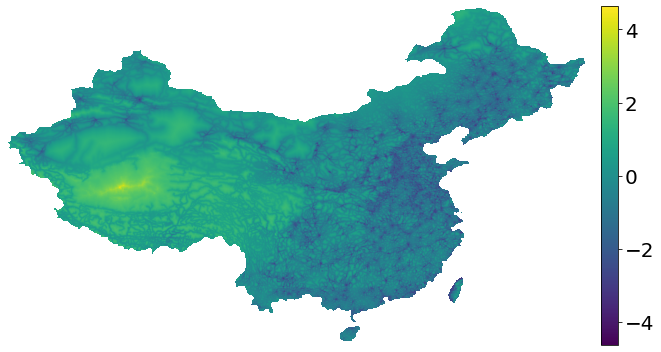

In [39]:
plot_raster_feature(flattened_feature_data=featureData["ACCESS"], name="ACCESS", save=True)

<pre>
<b>Code chunk 39</b>: plot raster data of the feature PET
</pre>

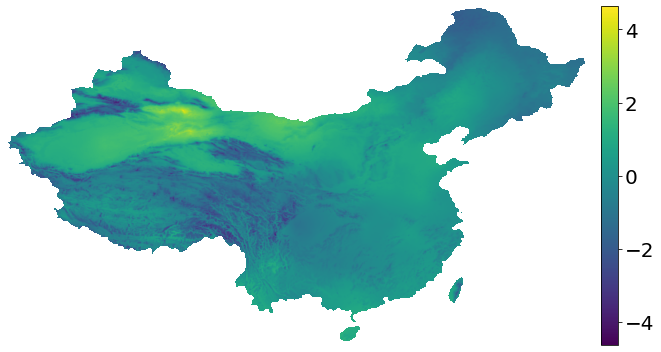

In [40]:
plot_raster_feature(flattened_feature_data=featureData["PET"], name="PET", save=True)

<pre>
<b>Code chunk 40</b>: plot raster data of the feature POP
</pre>

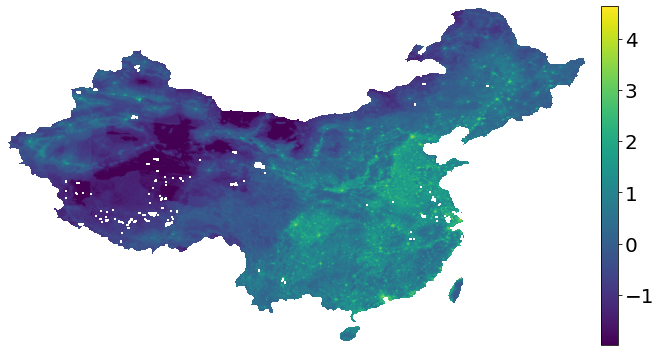

In [41]:
plot_raster_feature(flattened_feature_data=featureData["POP"], name="POP", save=True)

<pre>
<b>Code chunk 41</b>: plot raster data of the feature URBAN
</pre>

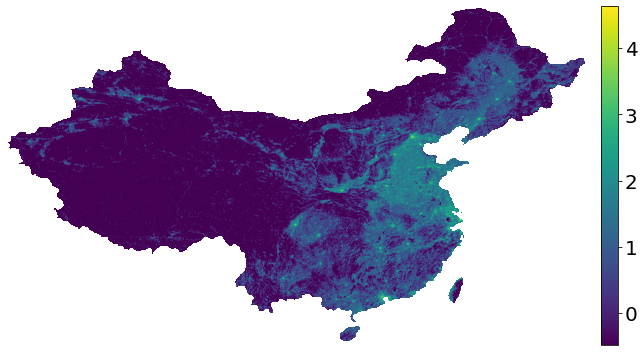

In [42]:
plot_raster_feature(flattened_feature_data=featureData["URBAN"], name="URBAN", save=True)

<pre>
<b>Code chunk 42</b>: plot raster data of the feature WACCESS
</pre>

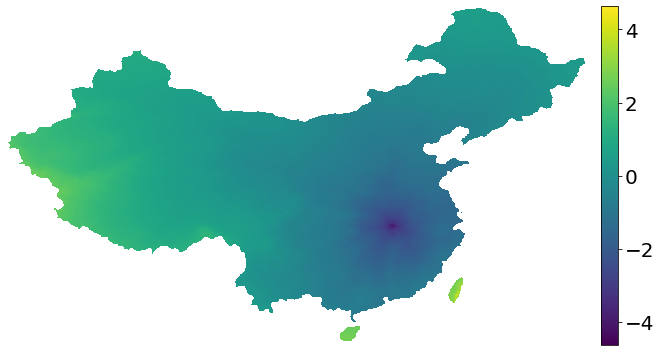

In [43]:
plot_raster_feature(flattened_feature_data=featureData["WACCESS"], name="WACCESS", save=True)

## 3.2. Mapping COVID-19 risk at fine spatial scale

We make fine-scale predictions of COVID-19 risk using the results from the best performing model (MLP1). Figure 2 shows the predicted values of LIR within 5×5 km2 grid-cells (548,255) that cover China. Note that the predicted values are on a natural log scale (dark colors: low values; bright colors: high values). White pixels inside China represent missing values. As expected, the highest LIR values are located in Hubei province, which is the presumed epicenter of the COVID-19 outbreak. The lowest LIR values are predicted in Northwest and Southwest China, which are far away (in both access time and distance) from the epicenter.

To obtain a local prediction of the magnitude of the COVID-19 associated with a given population size, we compute the log COVID-19 total confirmed cases (Jan-Mar 2020) (LTC) at fine spatial scales across China. We take the log of the product of IR with population size for each grid-cell. The results are illustrated in Figure 3. Consistently, the highest predicted values of LTC are located in Hubei province, which counts the largest number of cases in China.

<br>
<span style="font-size:12px">Figure 2 [generated by code chunk 41]: Map of predicted values of log COVID-19 incidence rate per 100,000 population (Jan-Mar 2020) (LIR) in China within a grid-cell composed of 548,255 pixels. The predictions are generated by multilayer perceptron with one hidden layer (MLP1). Predicted LIR values range from 0.0 to 3.7. White pixels represent missing data. </span>
<br><br>

![Figure 2](../data/predictions/colored/LIR_h1.jpg)

<br>
<span style="font-size:12px">Figure 3 [generated by code chunk 43]: Map of fine-scale predicted values of log COVID-19 total confirmed cases (Jan- Mar 2020) (LTC) in China within a grid-cell composed of 548,255 pixels. The predictions are generated by multilayer perceptron with one hidden layer (MLP1). Predicted LTC values range from 0.0 to 4.8. White pixels represent missing data. </span>
<br><br>

![Figure 3](../data/predictions/colored/LTC_h1.jpg)

<pre>
<b>Code chunk 41</b>: plot raster data of the LIR predictions
</pre>

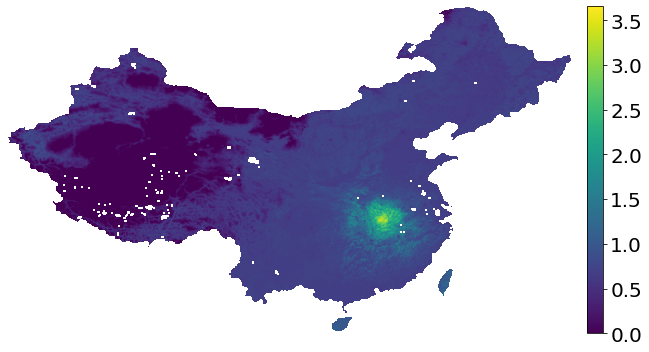

In [44]:
plot_rasters(raster_array=raster_data["LIR"],
             title="LIR",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["LIR"],
             save=True)

<pre>
<b>Code chunk 42</b>: plot raster data of the IR predictions
</pre>

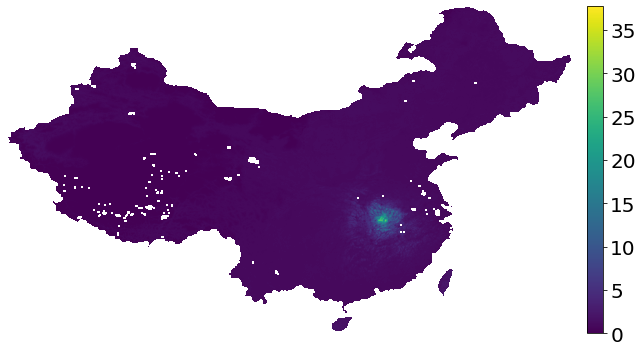

In [45]:
plot_rasters(raster_array=raster_data["IR"],
             title="IR",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["IR"],
             save=True)

<pre>
<b>Code chunk 43</b>: plot raster data of the LTC predictions
</pre>

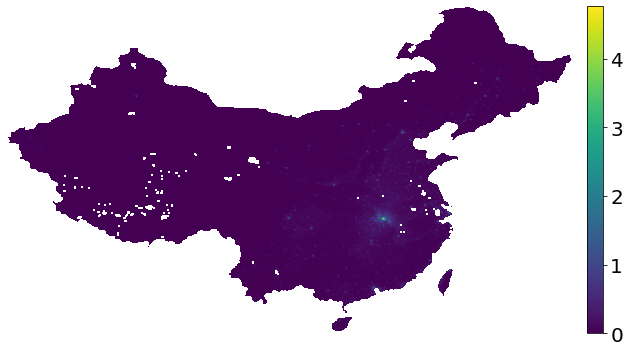

In [46]:
plot_rasters(raster_array=raster_data["LTC"],
             title="LTC",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["LTC"],
             save=True)

<pre>
<b>Code chunk 44</b>: plot raster data of the TC predictions
</pre>

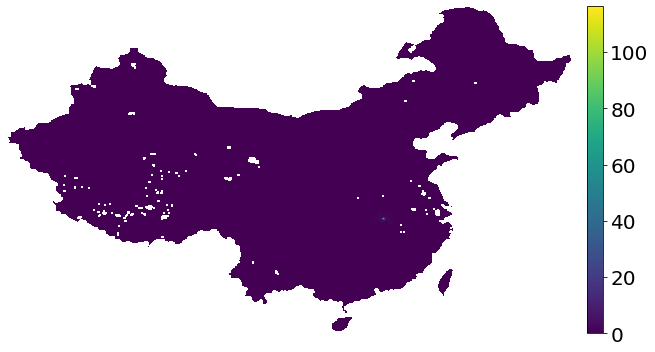

In [47]:
plot_rasters(raster_array=raster_data["TC"],
             title="TC",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["TC"],
             save=True)

## 3.4. Model validity

There is no available grid-cell data to assess the performance of predictions in locations that did not provide data. For that reason, we cannot systematically compare the observed and predicted values of TC at fine spatial scales across China. As an alternative, we compare the total confirmed number of cases (January to March 2020) provided by the reference COVID-19 dataset, JHU, with fine-scale predictions of TC aggregated at province-level.

Table A3 provides the TC data from JHU with province-level aggregated fine-scale predictions. Additionally, the table shows raw and percentage differences between the predictions and the external dataset. As expected, the largest discrepancy is observed in Hubei province, where the model underestimates TC, with a large deficit of counts of about 63,147. Given the outlier in Hubei province, an underestimation from the model is almost unavoidable. Also, it is likely that the data used in the model is less comprehensive than JHU, which may partially explain the observed discrepancy. The model slightly overestimates TC in Hebei province, with an added number of 365 cases and predicts 234 cases in Inner Mongolia, while JHU did not observe any cases over the investigated time. In this later case, we hypothesize delays in the reporting of cases. A more recent version (March 6, 2021) of JHU reports a total of 367 cases in Inner Mongolia observed since the initial outbreak in December 2019, which provides support to our hypothesis (JHU CSSE, 2020).

<br>
<span style="font-size:12px">Table A3 [generated by code chunk 47]: Summary table of province-level aggregated predictions of COVID-19 cases and JHU data from January to March 2020 (JHU CSSE, 2020). The table shows: (A) the name of the province (or municipality and special administrative region), the model prediction of the COVID-19 cases (B), the JHU data of the number of COVID-19 cases (C), the absolute difference (D), the log difference (E), and the relative difference (F) between model predictions and JHU data at province level. Rows are sorted by column D.</span>

|        A        |     B      |     C     |     D     |   E    |      F      |
| :-------------: | :--------: | :-------: | :-------: | :----: | :---------: |
| province/region | pred.cases | JHU cases | \|B-C}\|  | log(D) | (D/B) ⨉ 100 |
|      Hebei      |   686.13   |    321    |  365.13   |  2.56  |    53.22    |
|     Yunnan      |   456.37   |    182    |  274.37   |  2.44  |    60.12    |
|    Liaoning     |   386.56   |    139    |  247.56   |  2.39  |    64.04    |
| Inner Mongolia  |   234.37   |     0     |  234.37   |  2.37  |   100.00    |
|     Sichuan     |   780.24   |    550    |  230.24   |  2.36  |    29.51    |
|     Shanxi      |   357.51   |    136    |  221.51   |  2.35  |    61.96    |
|     Guizhou     |   358.55   |    146    |  212.55   |  2.33  |    59.28    |
|     Guangxi     |   462.62   |    254    |  208.62   |  2.32  |    45.10    |
|      Jilin      |   252.36   |    98     |  154.36   |  2.19  |    61.17    |
|     Jiangsu     |   780.30   |    646    |  134.30   |  2.13  |    17.21    |
|     Shaanxi     |   377.49   |    253    |  124.49   |  2.10  |    32.98    |
|      Gansu      |   252.93   |    138    |  114.93   |  2.06  |    45.44    |
|    Shandong     |   885.16   |    774    |  111.16   |  2.05  |    12.56    |
|      Hunan      |  1125.71   |   1018    |  107.71   |  2.03  |    9.57     |
|    Xinjiang     |   175.55   |    76     |   99.55   |  2.00  |    56.71    |
|     Qinghai     |   49.54    |    18     |   31.54   |  1.50  |    63.66    |
|     Taiwan      |   350.06   |    322    |   28.06   |  1.45  |    8.02     |
|     Xizang      |   22.12    |     1     |   21.12   |  1.32  |    95.48    |
|      Henan      |  1293.72   |   1276    |   17.72   |  1.25  |    1.37     |
|     Fujian      |   346.28   |    343    |   3.28    |  0.52  |    0.95     |
|     Ningxia     |   60.54    |    75     |  -14.46   |  1.16  |   -23.89    |
|     Hainan      |   136.68   |    168    |  -31.32   |  1.50  |   -22.92    |
|     Jiangxi     |   875.67   |    937    |  -61.33   |  1.79  |    -7.00    |
|     Tianjin     |   108.47   |    174    |  -65.53   |  1.82  |   -60.42    |
|      Anhui      |   902.15   |    990    |  -87.85   |  1.94  |    -9.74    |
|  Heilongjiang   |   339.04   |    484    |  -144.96  |  2.16  |   -42.76    |
|    Chongqing    |   297.53   |    579    |  -281.47  |  2.45  |   -94.60    |
|    Shanghai     |   199.92   |    509    |  -309.08  |  2.49  |   -154.61   |
|     Beijing     |   157.47   |    580    |  -422.53  |  2.63  |   -268.33   |
|    Guangdong    |   953.11   |   1494    |  -540.89  |  2.73  |   -56.75    |
|    Hong Kong    |   42.69    |    714    |  -671.31  |  2.83  |  -1572.44   |
|    Zhejiang     |   523.41   |   1257    |  -733.59  |  2.87  |   -140.15   |
|      Hubei      |  4653.73   |   67801   | -63147.27 |  4.80  |  -1356.92   |

<br>

To assess the validity of the model with external data, we compute the RMSE, MAE and R2 metrics associated with the difference in TC between the predictions and JHU data at province level (Table 2). We show the computed metrics based on all provinces (first row) and without Hubei province (second row). Computing the metrics without outlier values (in Hubei) allows us to better capture the overall differences between the predictions of the model and JHU data in all provinces except in Hubei province, which accounts for most differences.

<br>
<span style="font-size:12px">Table 2 [generated by code chunk 48]: Metrics, root mean squared error (RMSE), mean absolute error (MAE) and R2, calculated for differences between aggregated fine-scale predictions of COVID-19 total confirmed cases (Jan-Mar 2020) (TC) and JHU data (Jan-Mar 2020) at province level in China. Calculations are conducted for 33 (all) provinces including Hubei province and for 32 without Hubei province. Fine-scale values of TC (548,255 in total) were predicted by multilayer perceptron with one hidden layer (MLP1).</span>

|                | RMSE     | MAE     | R<sup>2</sup> |
|----------------|----------|---------|----------------|
| All  provinces | 10995.69 | 2104.67 | 0.094          |
| Without Hubei  | 267.82   | 197.09  | 0.564          |

<br>

As expected, the RMSE and MAE based on all provinces including Hubei are one to two orders of magnitude higher than those computed in all provinces except Hubei. The large values of the RMSE compared to MAE obtained when all provinces are considered indicate that one or a few provinces exhibit differences that are much larger than the average differences observed in other provinces, since RMSE puts higher penalty (squared errors) on larger differences. In the assessment that excludes Hubei, the total variance in JHU data is improved, with about 56% of the variance that can be explained by the predictive model.

Figure 4 shows the differences between the predictions of COVID-19 cases and JHU data for each province in China. In particular, it captures a negative difference of 63,147 TC in Hubei province (number 14). The second largest differences are observed in Hebei province, where the predictive values show a positive difference of 365 cases compared to JHU data.

<br>
<span style="font-size:12px">Figure 4 [generated by code chunk 46]: Differences (log10) between aggregated fine-scale predictions of COVID-19 total confirmed cases (Jan-Mar 2020) (TC) and JHU data (Jan-Mar 2020) at province level in China. The map includes 33 Chinese provinces, which are numerated in alphabetical order. Fine-scale values of TC (548,255 pixels in total) were predicted by multilayer perceptron with one hidden layer (MLP1).</span>
<br><br>

![Figure 4](../data/predictions/shapefiles/plots/diff_log10.jpg)

<pre>
<b>Code chunk 45</b>: get JHU data and model predictions at province level in a shapefile format
</pre>

In [48]:
predicted_with_JHU, predicted_with_JHU_without_hubei = get_province_data(JHU_file_path=ROOT_DIR + "/data/csvs/JHU/JHUJanMar.csv", 
                                                                         predictions_shapefile_path=ROOT_DIR + "/data/predictions/shapefiles/{}.shp".format(CURRENT_CONFIG['shapefile']['file_name']))


<pre>
<b>Code chunk 46</b>: plot log differences between aggregated predicted cases and JHU data on province level
</pre>

## <center>predicted cases - JHU (log10)</center>

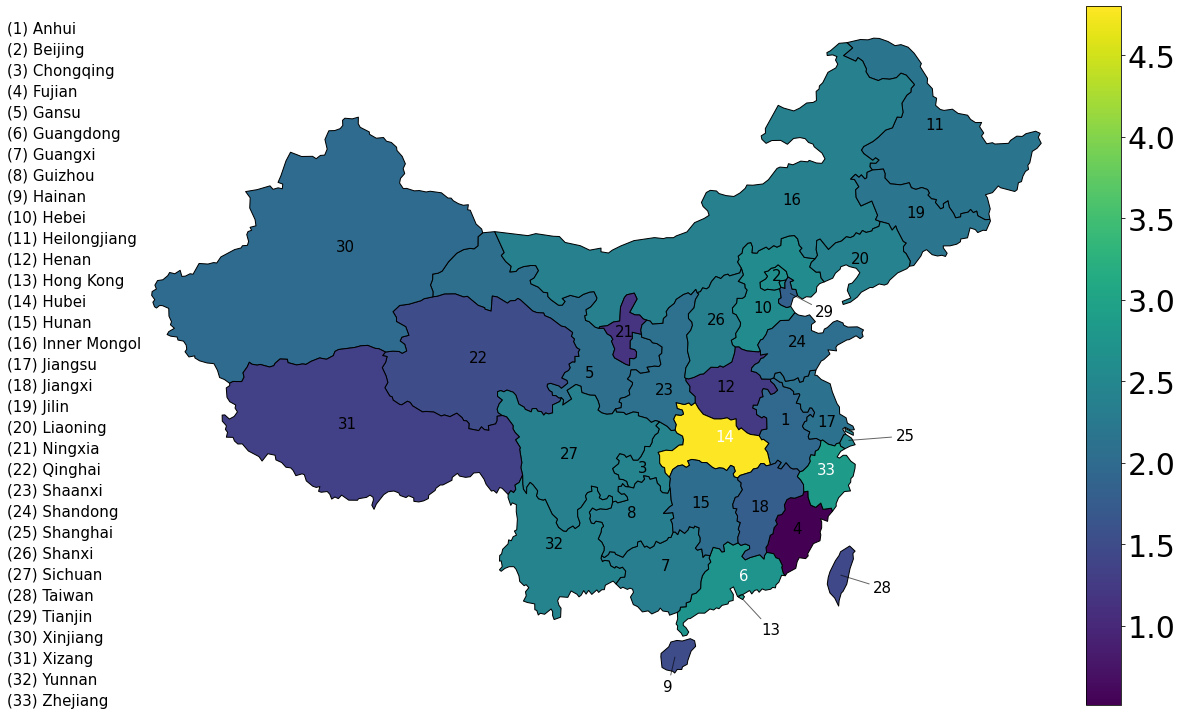

In [49]:
plot_shapefile_map(data=predicted_with_JHU,
         column_name="diff_log10",
         title="predicted cases - JHU (log10)",
         save=True)

<pre>
<b>Code chunk 47</b>: generate a table for differences, aggregated predicted cases and JHU data on province level
</pre>

In [50]:
(predicted_with_JHU
    .sort_values(by="differences",
               ascending=False)
    .rename(columns={"uniqu_d": "province",
       "TC": "prediction",
       "JHU_cases": "JHU",
       "differences": "difference",
       "diff_log10": "difference (log10)",
       "differences_p": "difference (%)"
      }).drop(["geometry"], axis=1))

,province,admin,prediction,JHU,difference,difference (log10),difference (%)
9,Hebei,China,686.133423,321,365.133423,2.562452,53.216096
31,Yunnan,China,456.369965,182,274.369965,2.438337,60.120075
19,Liaoning,China,386.562653,139,247.562653,2.393685,64.042051
15,Inner Mongol,China,234.367508,0,234.367508,2.369897,100.000000
26,Sichuan,China,780.240112,550,230.240112,2.362181,29.508879
25,Shanxi,China,357.507568,136,221.507568,2.345389,61.958847
7,Guizhou,China,358.551727,146,212.551727,2.327465,59.280631
6,Guangxi,China,462.623962,254,208.623962,2.319364,45.095797
18,Jilin,China,252.361237,98,154.361237,2.188538,61.166778
16,Jiangsu,China,780.299316,646,134.299316,2.128074,17.211256


<pre>
<b>Code chunk 48</b>: log metrics for a comparison of aggregated total cases and JHU data on province level
</pre>

In [51]:
metrics_predictions_vs_JHU(predicted_with_JHU).round(3)

,RMSE,MAE,R2
All provinces,10995.692,2104.671,0.094
Without Hubei,267.816,197.090,0.564


# 4. Conclusion

Our work contributed to make deep learning algorithms reproducible. The inherent properties of deep learning algorithms along with incompatibility issues are potential barriers of reproducibility. Here we suggested a framework to prevent such issues, which was illustrated in a case study that applied a deep learning algorithm to predict fine-scale COVID-19 cases in China from January to March 2020. To assess the predictive performance of the model, we compared and mapped the differences in the COVID-19 total confirmed cases (Jan-Mar 2020) (TC) values from the predictions (aggregated within each Chinese province) with those obtained at province-level from a global COVID-19 reference dataset (JHU). While the model identified the overall spatial pattern of TC values, important discrepancies remained in various provinces in China between the predicted values from the model and the reference dataset. 

The novelty of our work is to provide a user-friendly and efficient framework for the analysis of spatial data that requires the use of complex models whose results are difficult to reproduce. Within the suggested framework, results can be easily reproduced and adapted to other contexts. We hope that our framework can be used for the review process of academic journals, policymaking, and in any work that requires or benefits from an efficient and reliable platform to facilitate peer-review, ensure the validity of scientific findings, and share results with partners using different operating systems and IT architectures. Furthermore, this framework also facilitates obtaining consistent results where models are regularly updated with new data.

In line with Peng (2011), we believe that reproducibility and replicability can be achieved if the research community follows a few best practices that include the use of code and procedures that are available to all in a controlled computing environment. We hope that this study will encourage the research community to promote and adopt this framework, and hence, contribute to ensure scientific progress and the generation of knowledge.
